In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
sns.set(color_codes=True)
from pylab import rcParams
rcParams['figure.figsize'] = 40, 10
from IPython.core.display import display, HTML
from datetime import datetime
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
py.init_notebook_mode(connected=True)

In [2]:
colors = {
    'Google': '#349c47',
    'OpenDNS': '#f16422',
    'Telstra': '#5374ba'
}

In [3]:
jan_11 = datetime(2017,1,11)
data = pd.read_csv('data.csv', delimiter=';', parse_dates=['date'])
data = data.set_index(['date'])
data = data.sort_index()
data = data.dropna()
data = data[data.index >= jan_11]
print(data['dns1'].unique(), data['dns2'].unique(), data['dns3'].unique())
data.to_csv('after_11_jan.csv')
data = data.drop(['dns1', 'dns2', 'dns3'], axis=1)
data.describe()

[' 208.67.222.222'] [' 8.8.8.8'] [' SYS-61.9.133.193']


OpenDNS        Google       Telstra
count  10767.000000  10767.000000  10767.000000
mean      98.183232    116.960422     23.290184
std       19.961303     25.460378      6.181540
min       46.920000     63.300000     14.580000
25%       87.420000    104.065000     19.680000
50%       96.570000    114.500000     22.480000
75%      105.800000    125.215000     25.585000
max     1190.290000   1416.480000    164.230000

In [4]:
dns_providers = ['OpenDNS', 'Google', 'Telstra']

In [5]:
from scipy.stats import normaltest
for dns in dns_providers:
    pvalue = normaltest(data[dns]).pvalue
    if pvalue < 0.05:
        print("{} response times is not from the normal distribution, pvalue={}".format(dns, pvalue))
    else:
        print("{} response times comes from the normal distribution, pvalue={}".format(dns, pvalue))

OpenDNS response times is not from the normal distribution, pvalue=0.0
Google response times is not from the normal distribution, pvalue=0.0
Telstra response times is not from the normal distribution, pvalue=0.0


In [6]:
import itertools
from scipy.stats import ttest_ind
for dns1, dns2 in itertools.combinations(dns_providers, 2):
    pvalue = ttest_ind(data[dns1], data[dns2]).pvalue
    if pvalue < 0.05:
        print("{} mean response time differs from mean response time of the {}, pvalue={}".format(dns1, dns2, pvalue))
    else:
        print("{} mean response time same as mean response time of the {}, pvalue={}".format(dns1, dns2, pvalue))

OpenDNS mean response time differs from mean response time of the Google, pvalue=0.0
OpenDNS mean response time differs from mean response time of the Telstra, pvalue=0.0
Google mean response time differs from mean response time of the Telstra, pvalue=0.0


In [7]:
for dns in dns_providers:
    display(HTML('<h2>{}</h2>'.format(dns)))
    percentiles = "\n".join(["<li>{:.0f} percentile is {} ms</li>".format(percentile*100, data[dns].quantile(q=percentile, interpolation='nearest')) for percentile in [0.5, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99] ])
    display(HTML('<ul>{}</ul>'.format(percentiles)))
    # we can compute confidence interval of mean response time because of CLT
    conf_interval = st.norm.interval(0.95, loc=np.mean(data[dns]), scale=np.std(data[dns])/np.sqrt(len(data[dns])))
    print("95% confidence interval for mean response time of {} is ({:.2f}, {:.2f})ms".format(dns, conf_interval[0], conf_interval[1]))
    display(HTML('<hr/>'))

95% confidence interval for mean response time of OpenDNS is (97.81, 98.56)ms


95% confidence interval for mean response time of Google is (116.48, 117.44)ms


95% confidence interval for mean response time of Telstra is (23.17, 23.41)ms


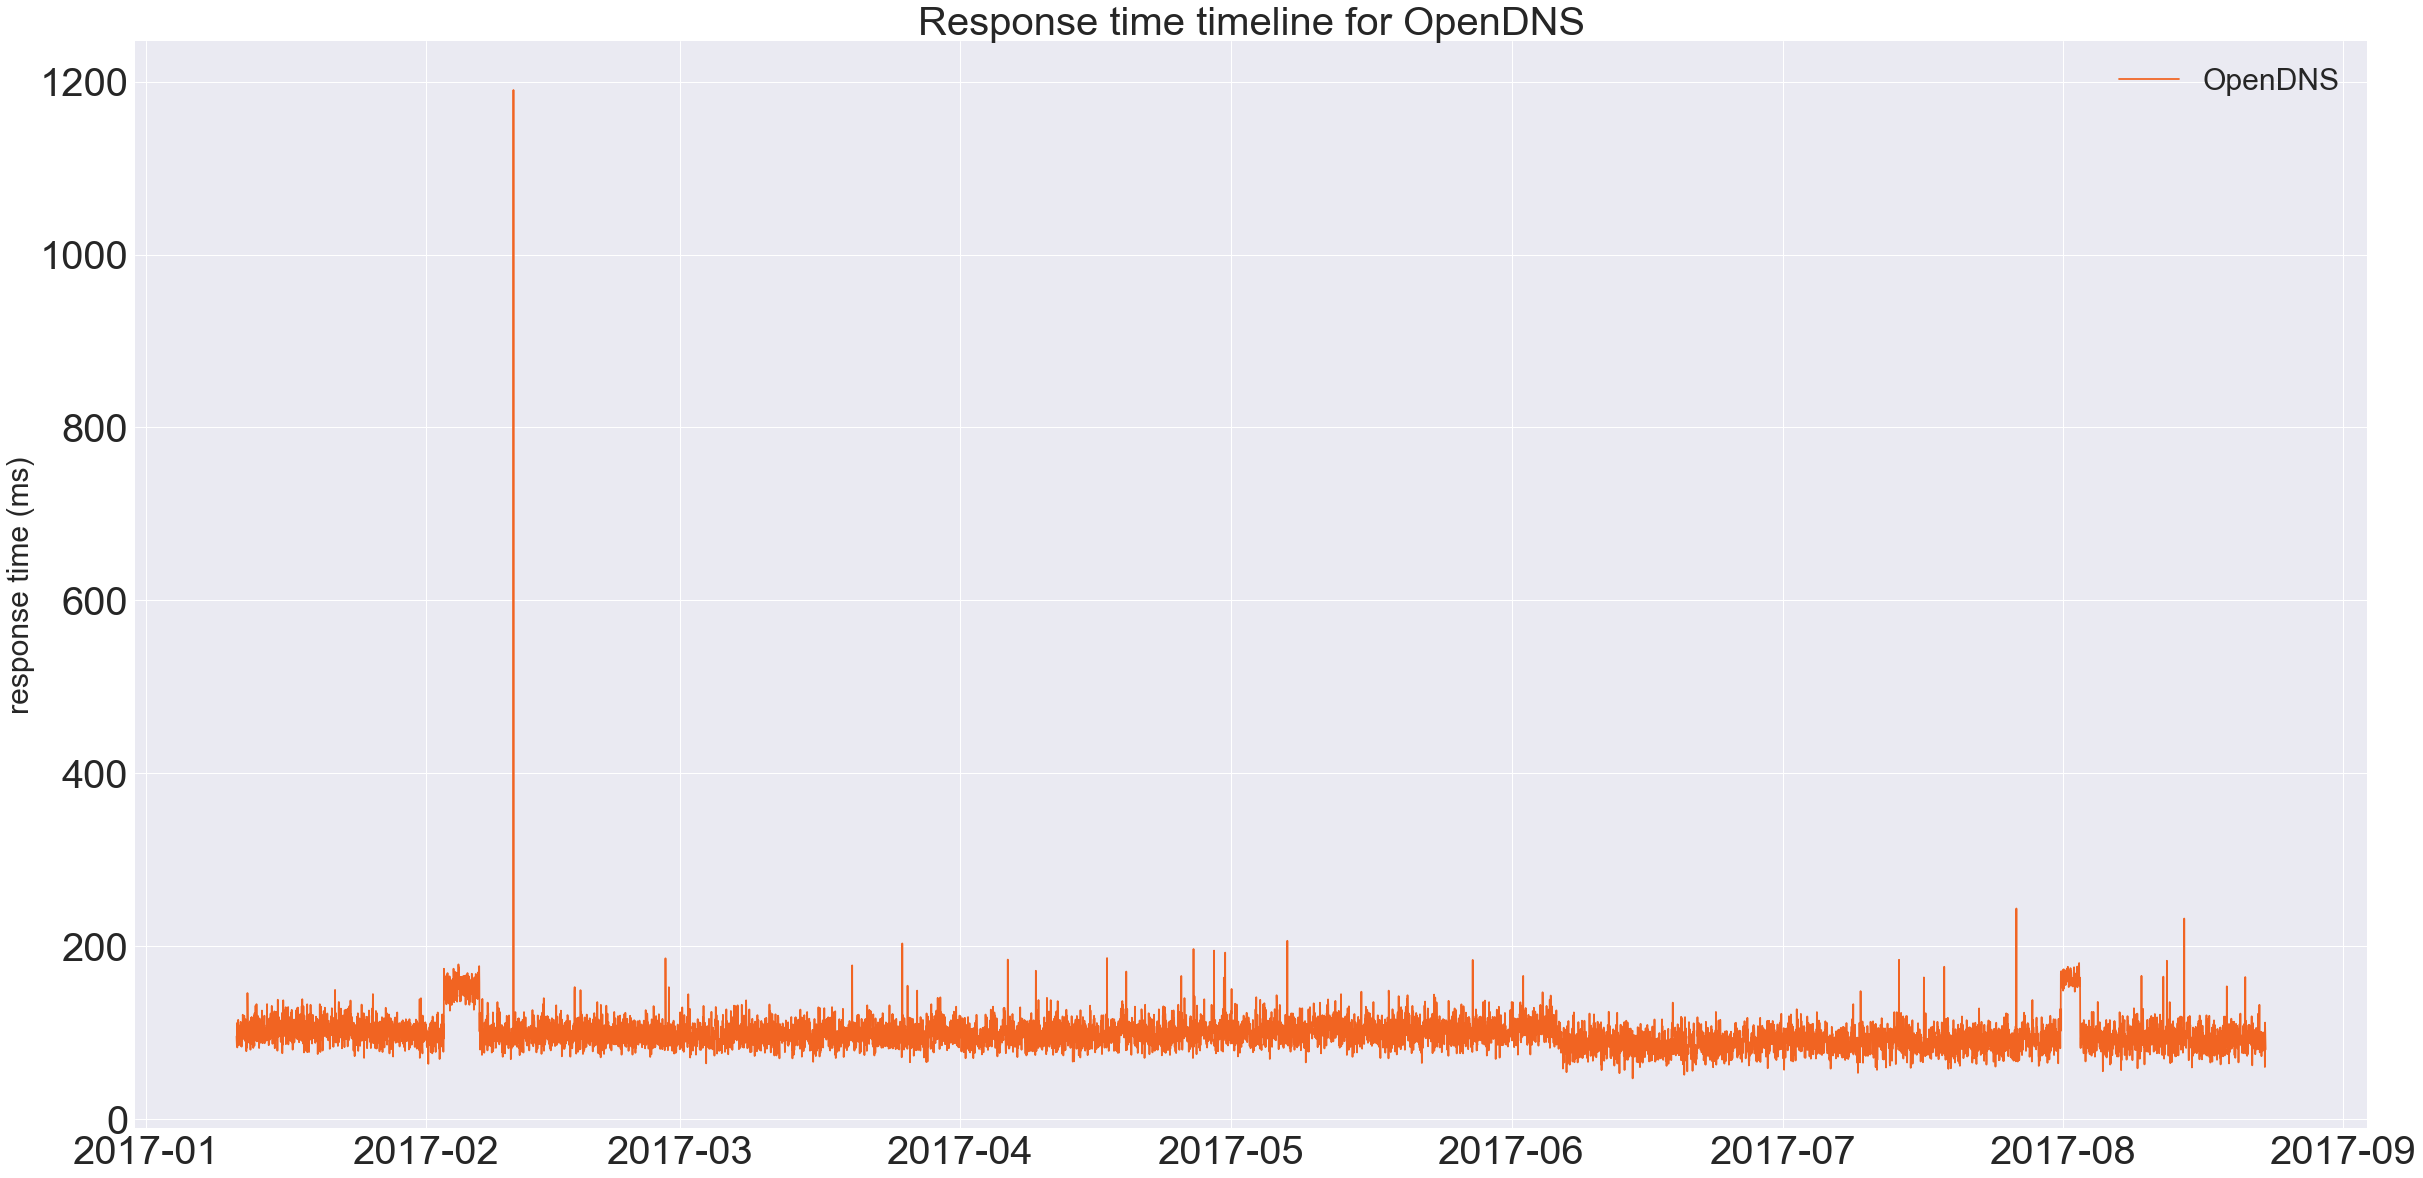

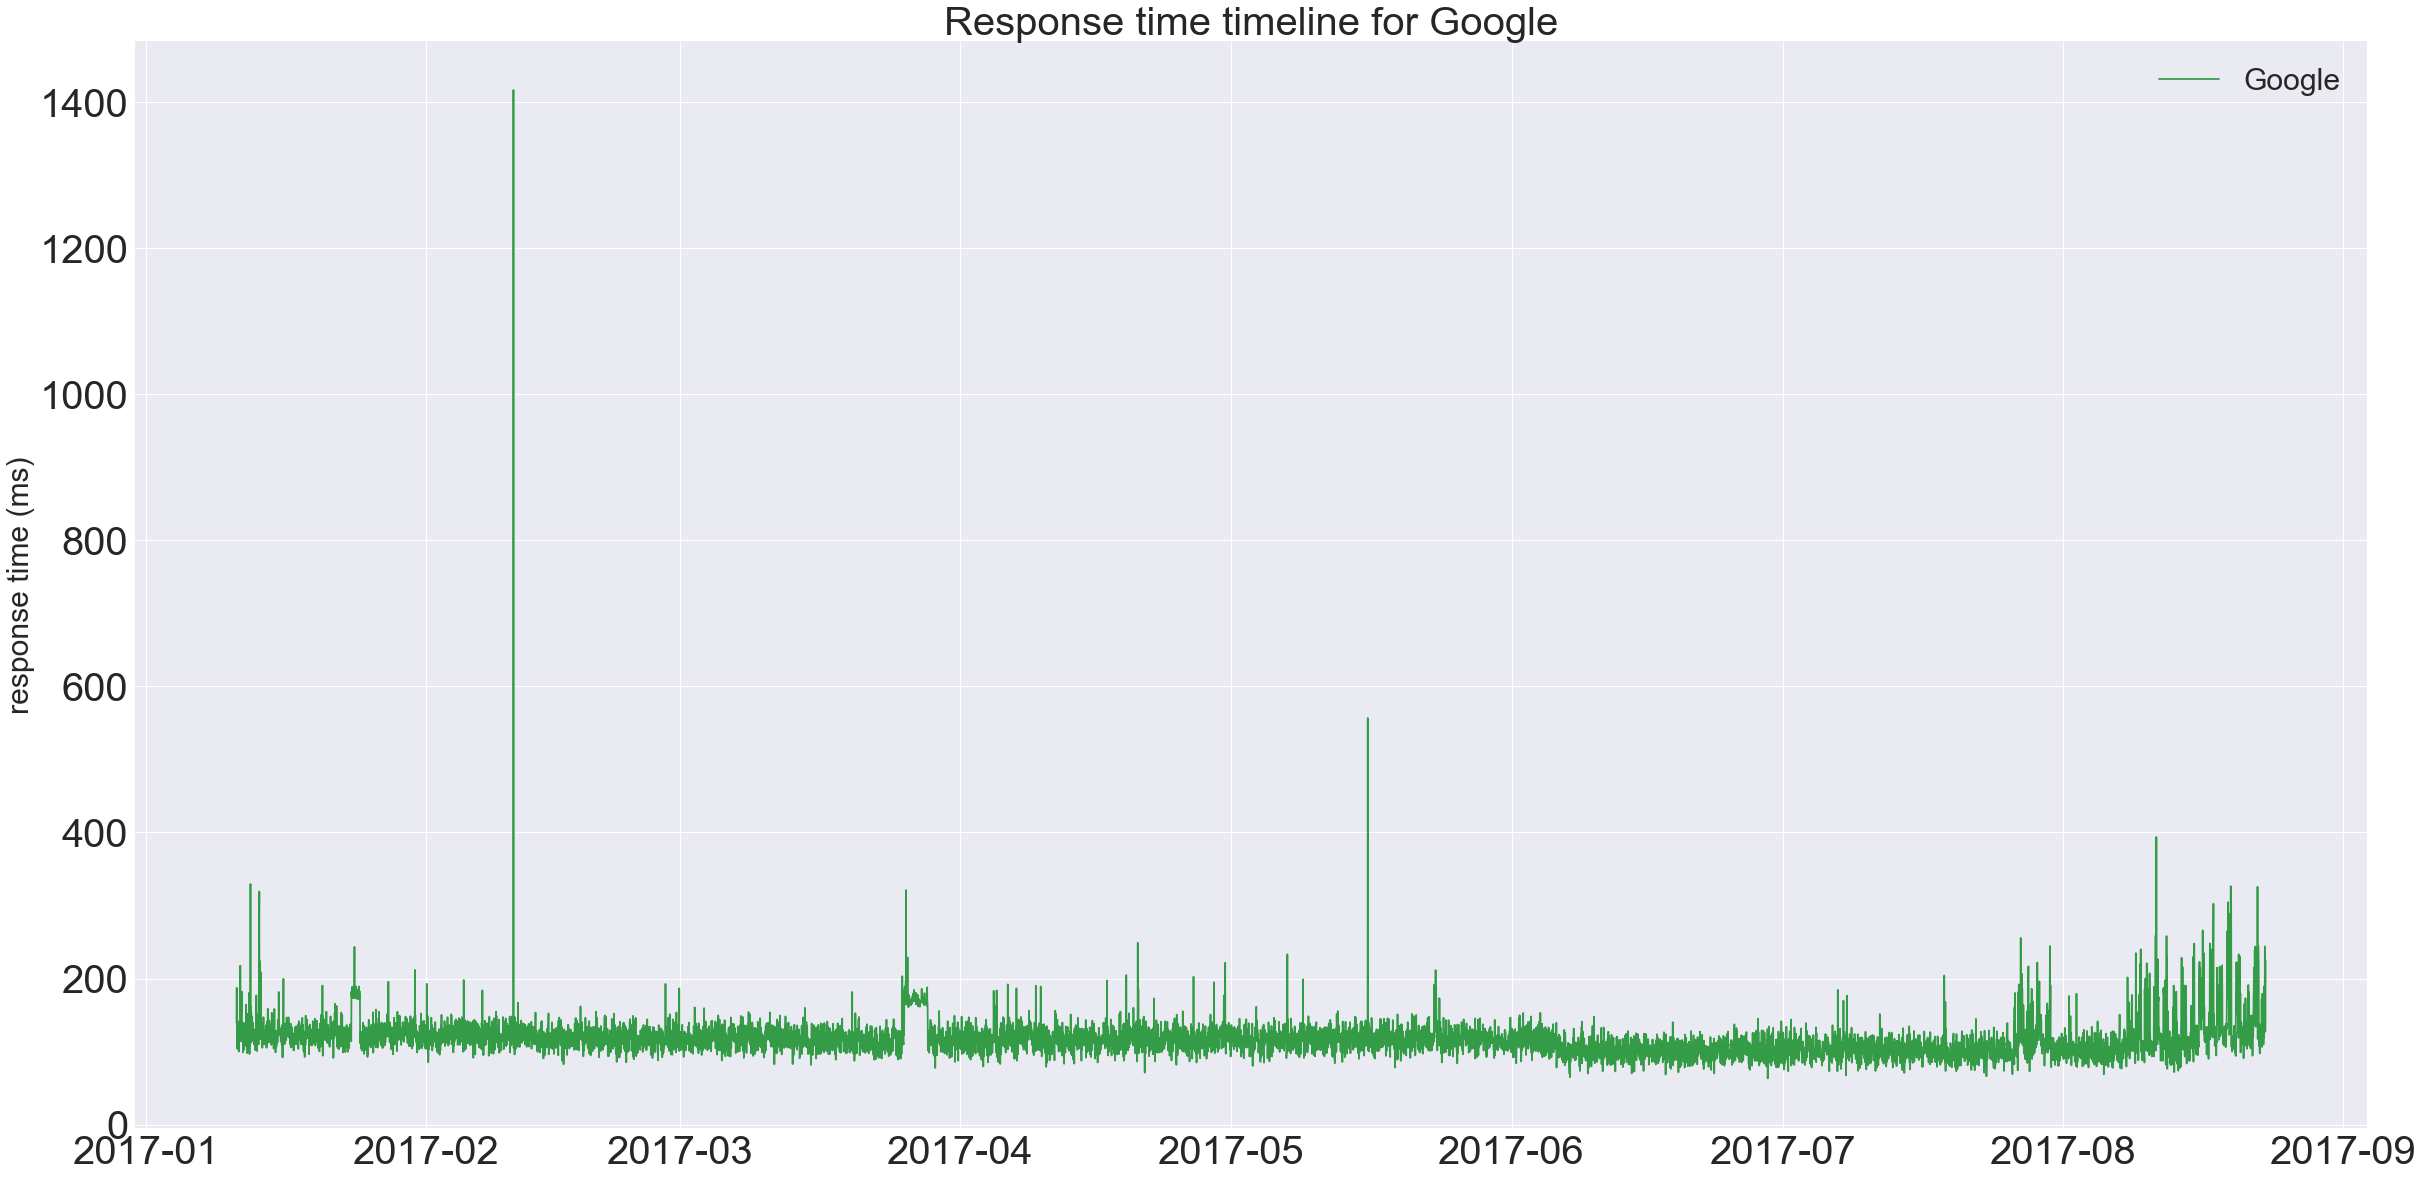

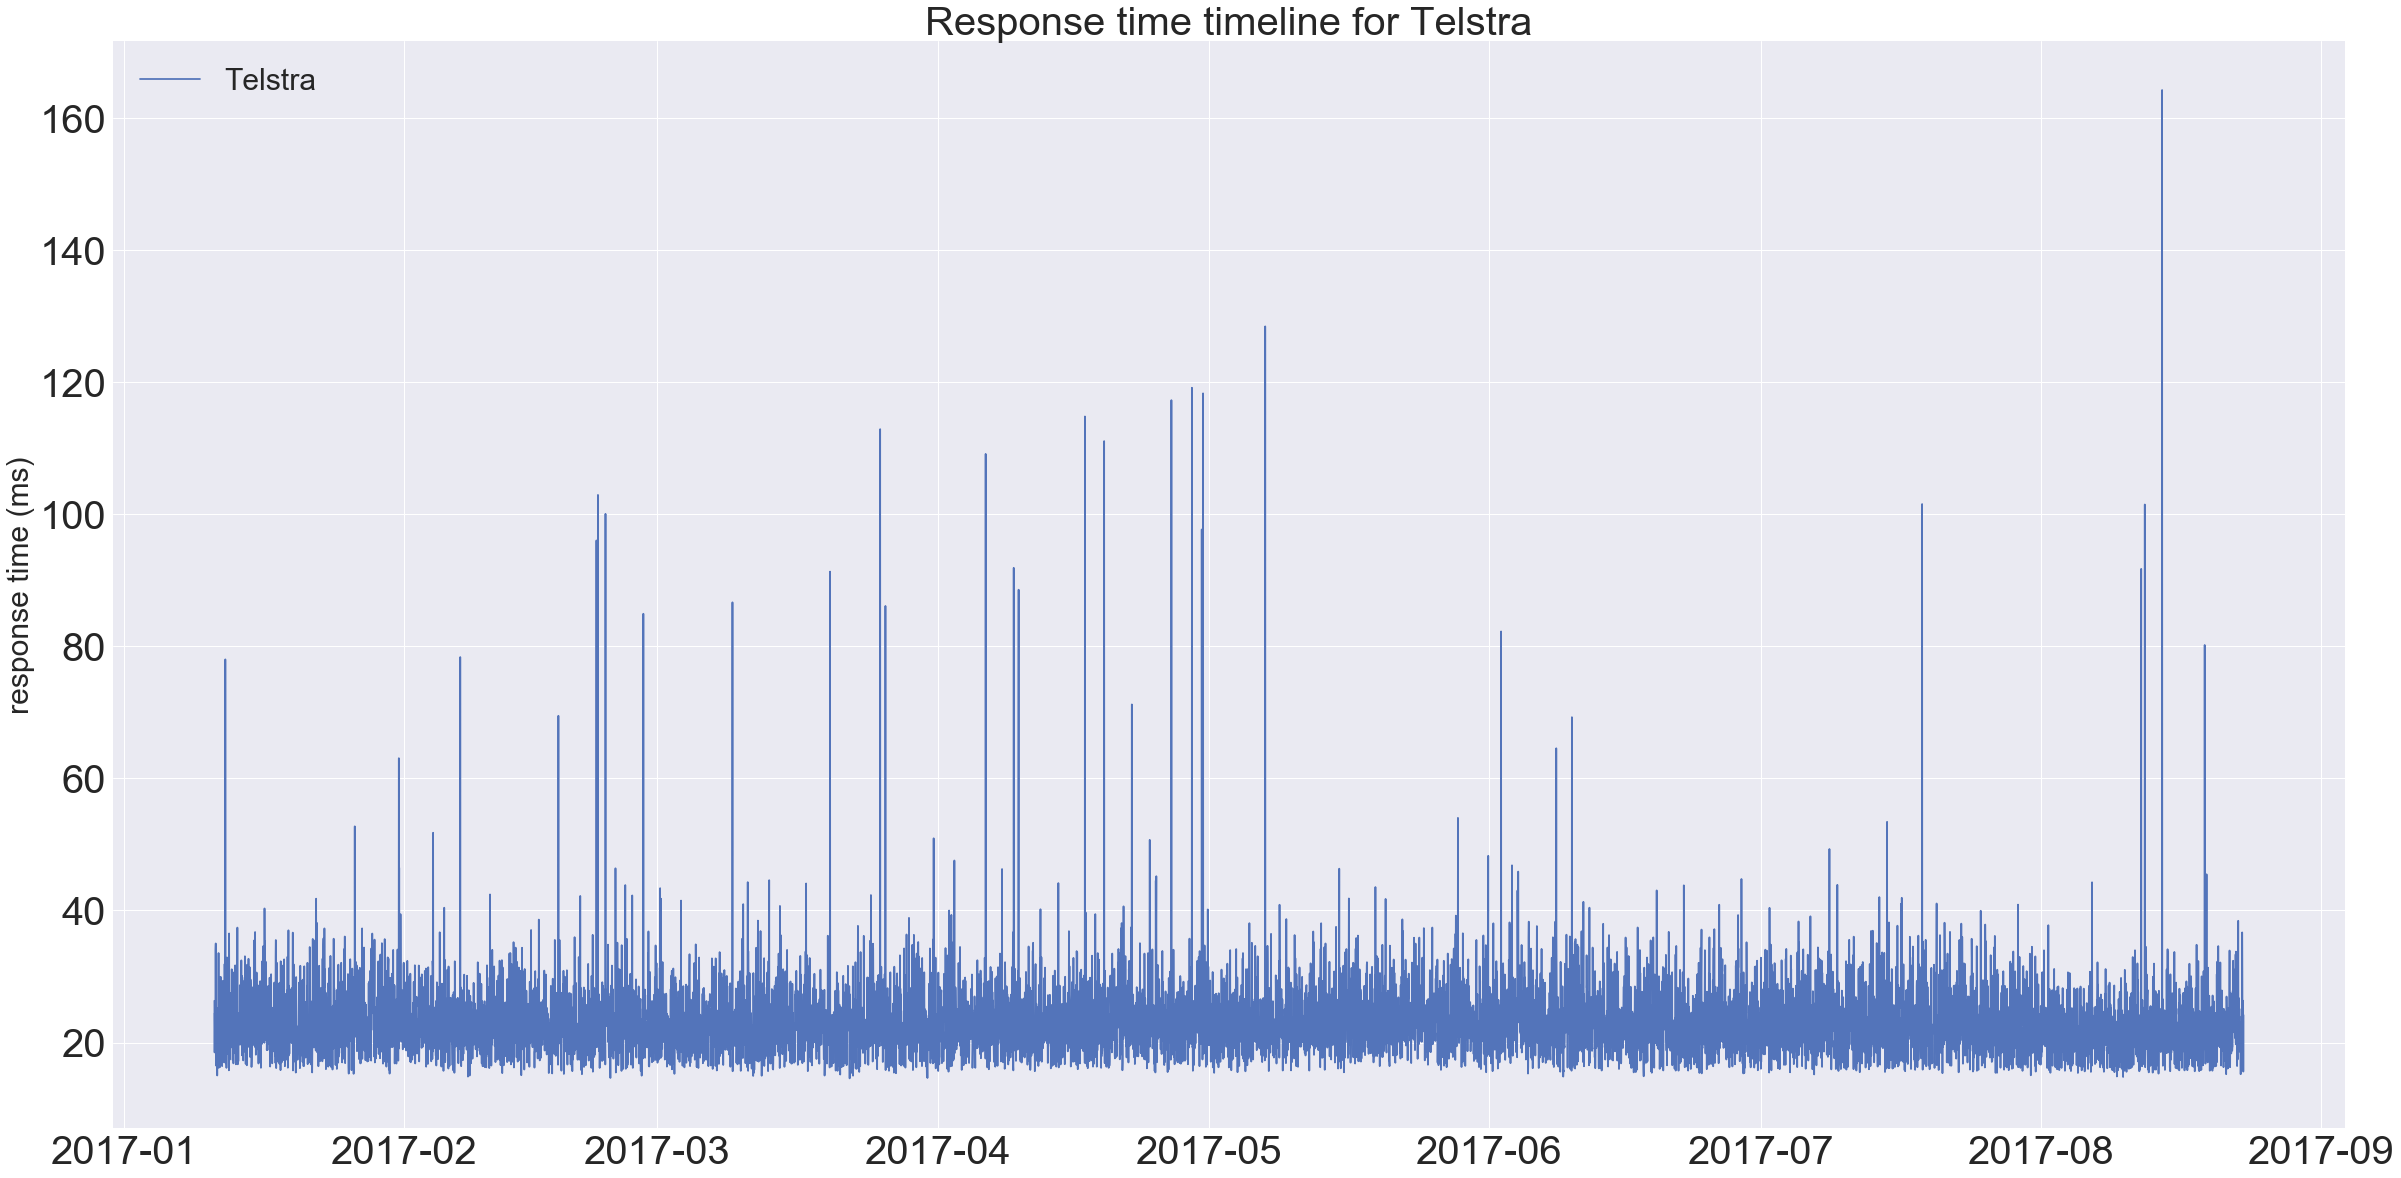

In [8]:
rcParams['figure.figsize'] = 40, 20
response_time_plots = []
for dns_provider in dns_providers:
    plt.plot(data[dns_provider], label=dns_provider, c=colors[dns_provider])
    plt.legend(prop={'size': 30})
    plt.tick_params(axis='both', which='major', labelsize=40)
    plt.tick_params(axis='both', which='minor', labelsize=15)
    plt.ylabel('response time (ms)', fontsize=30)
    plt.title('Response time timeline for {}'.format(dns_provider), size=40)
    plt.show()

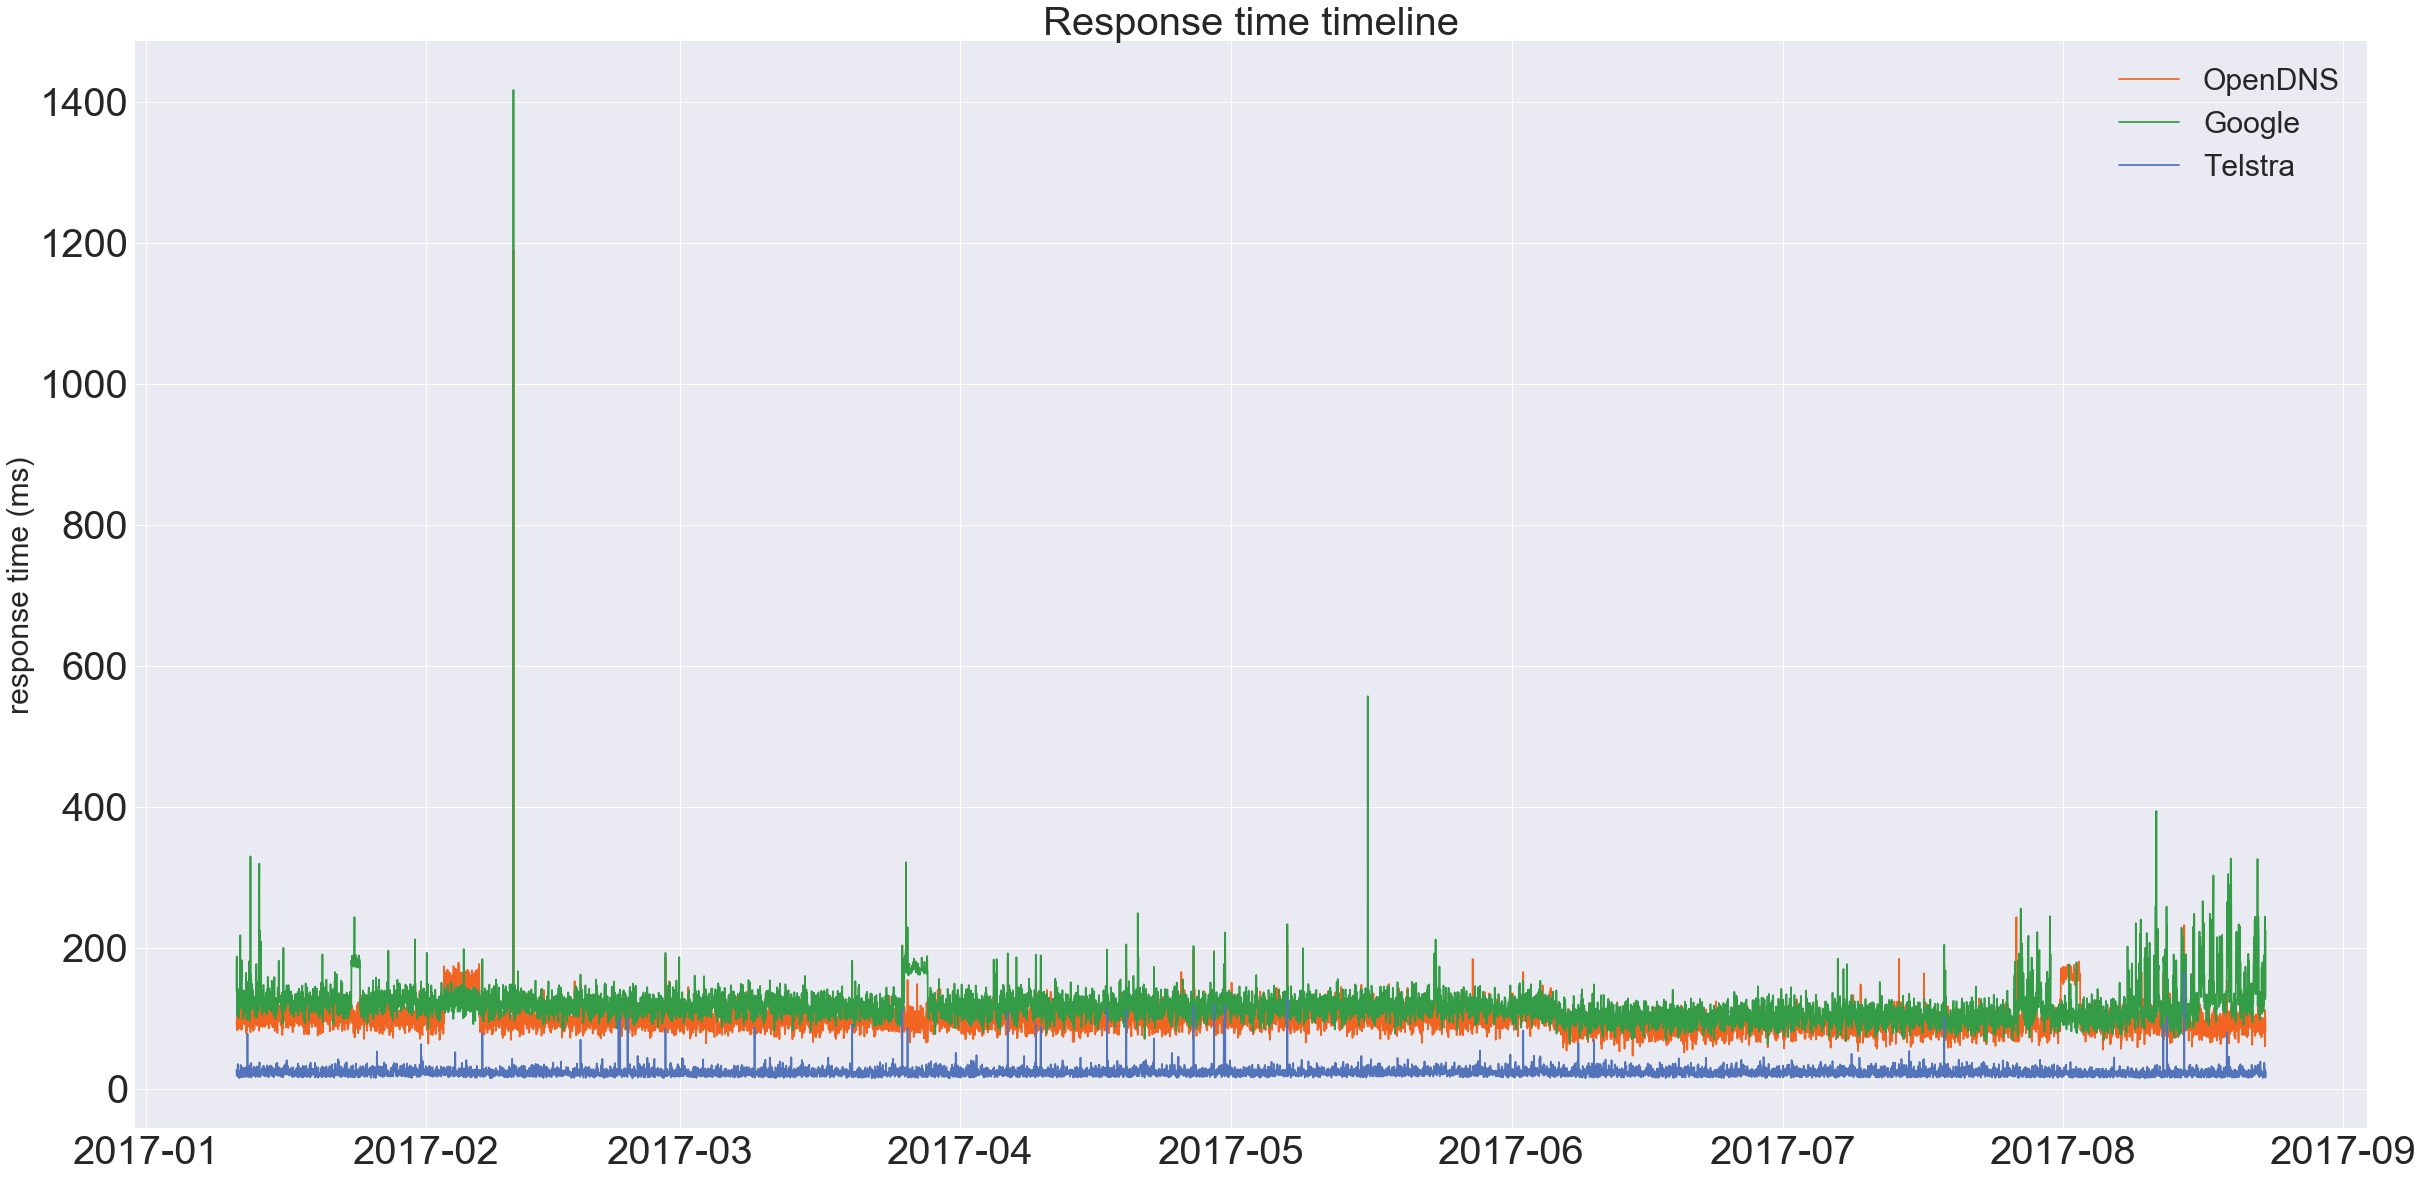

In [9]:
rcParams['figure.figsize'] = 40, 20
response_time_plots = []
for dns_provider in dns_providers:
    plt.plot(data[dns_provider], label=dns_provider, c=colors[dns_provider])
plt.legend(prop={'size': 30})
plt.tick_params(axis='both', which='major', labelsize=40)
plt.tick_params(axis='both', which='minor', labelsize=15)
plt.ylabel('response time (ms)', fontsize=30)
plt.title('Response time timeline', size=40)
plt.show()

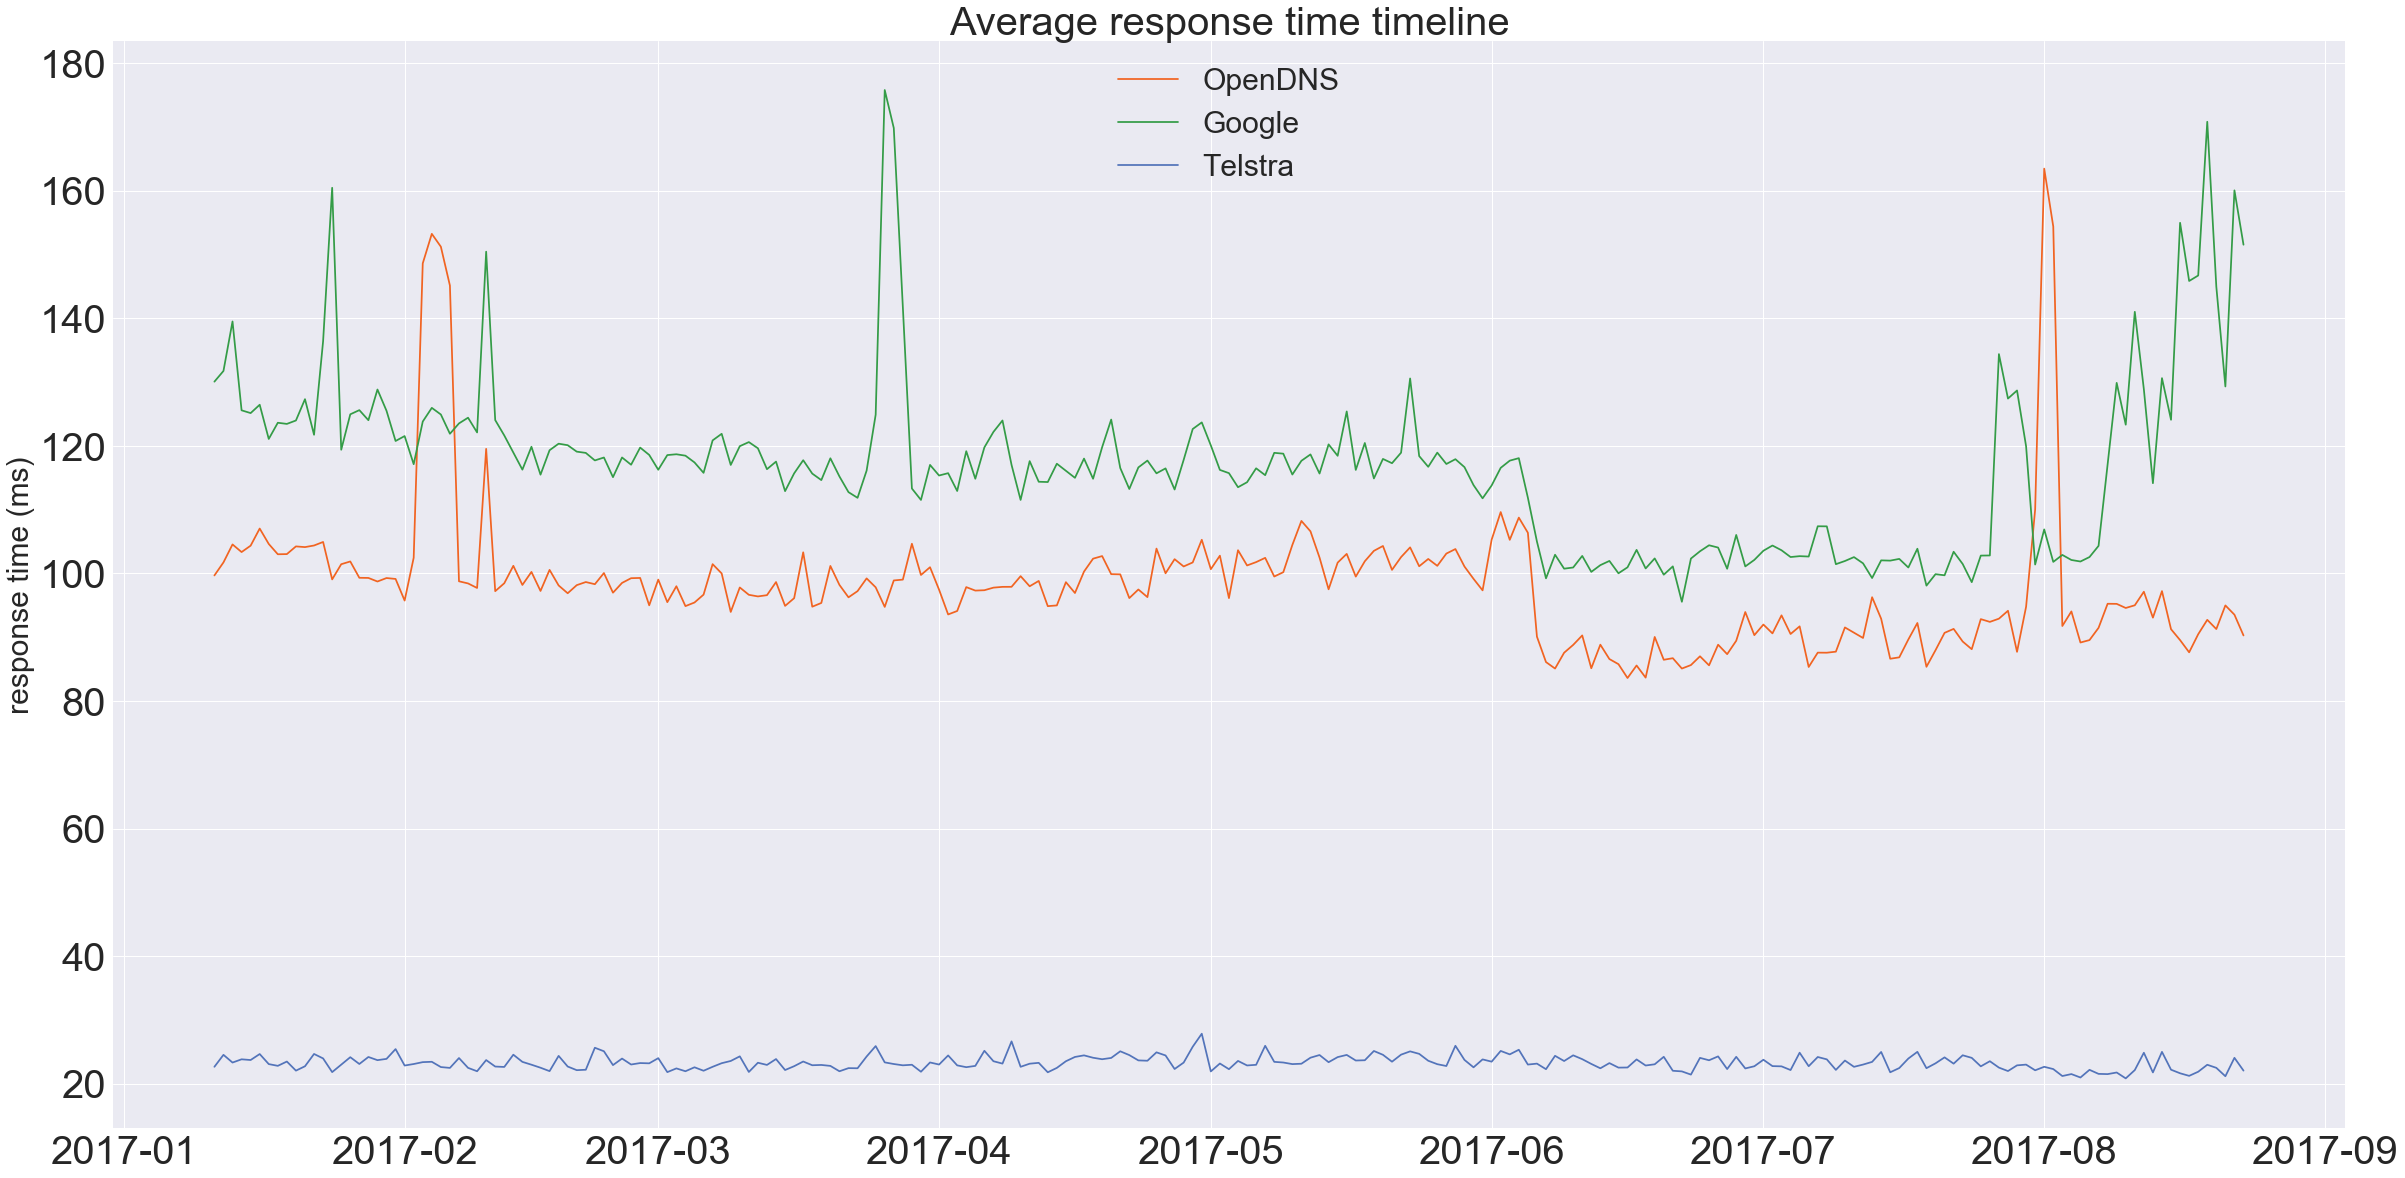

In [10]:
rcParams['figure.figsize'] = 40, 20
response_time_plots = []
for dns_provider in dns_providers:
    plt.plot(data[dns_provider].resample('1D').mean(), label=dns_provider, c=colors[dns_provider])
plt.legend(prop={'size': 30})
plt.tick_params(axis='both', which='major', labelsize=40)
plt.tick_params(axis='both', which='minor', labelsize=15)
plt.ylabel('response time (ms)', fontsize=30)
plt.title('Average response time timeline', size=40)
plt.show()

In [11]:
data = data[data['Google'] != data['Google'].max()]
data = data[data['OpenDNS'] != data['OpenDNS'].max()]

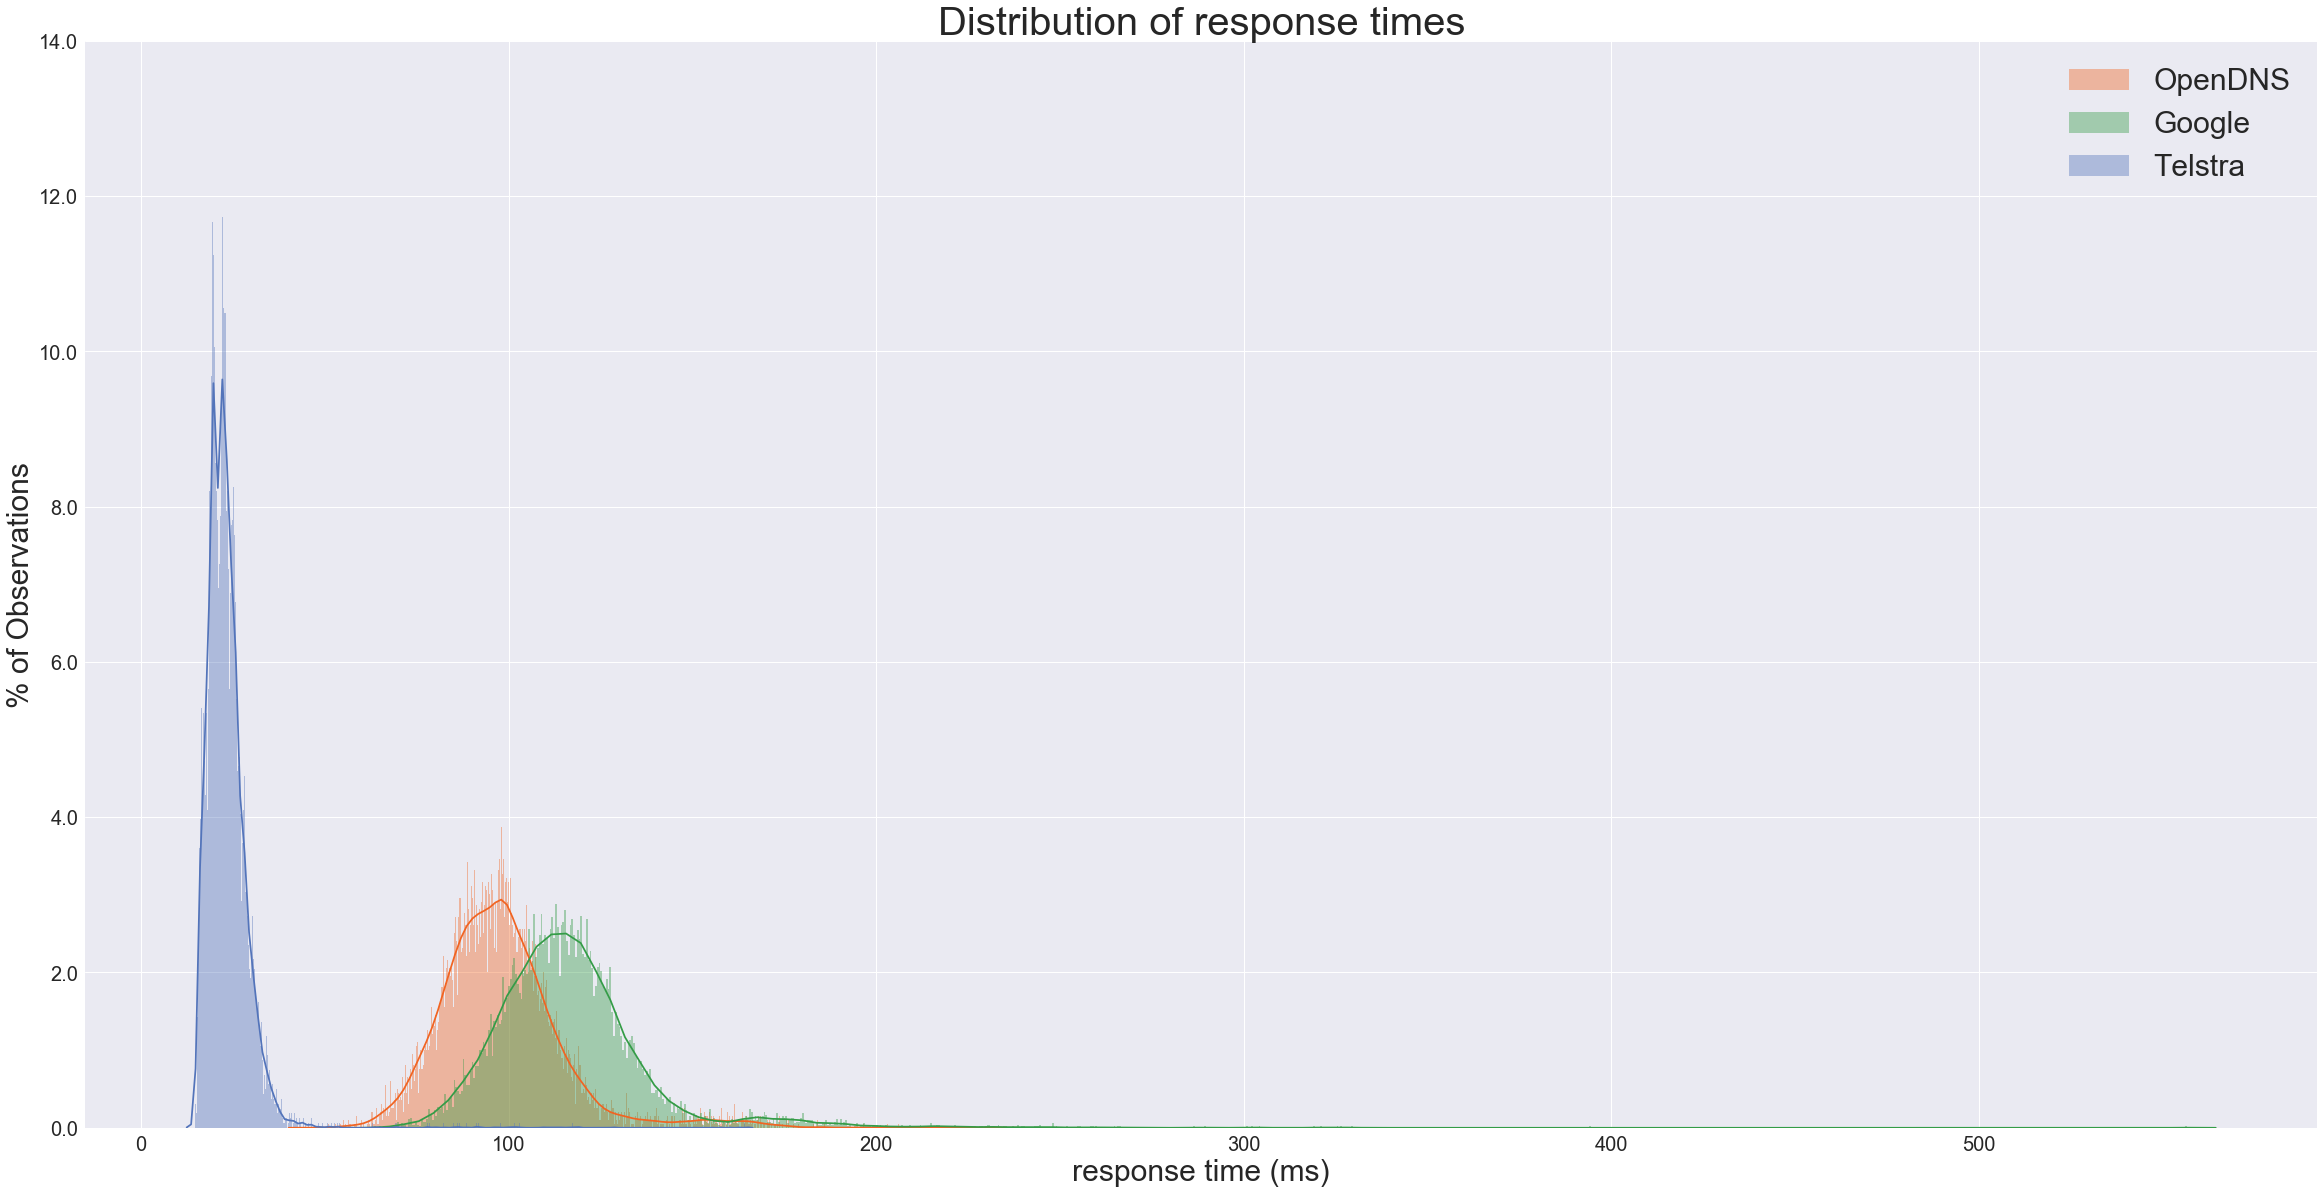

In [12]:
rcParams['figure.figsize'] = 40, 20
for dns in dns_providers:
    fig = sns.distplot(data[dns], label=dns, bins=1000, color=colors[dns])
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=15)
plt.xlabel('response time (ms)', fontsize=30)
plt.ylabel('% of Observations', fontsize=30)
plt.title('Distribution of response times', size=40)
plt.yticks(fig.get_yticks(), fig.get_yticks()*100)
plt.legend(prop={'size': 30})
plt.show()

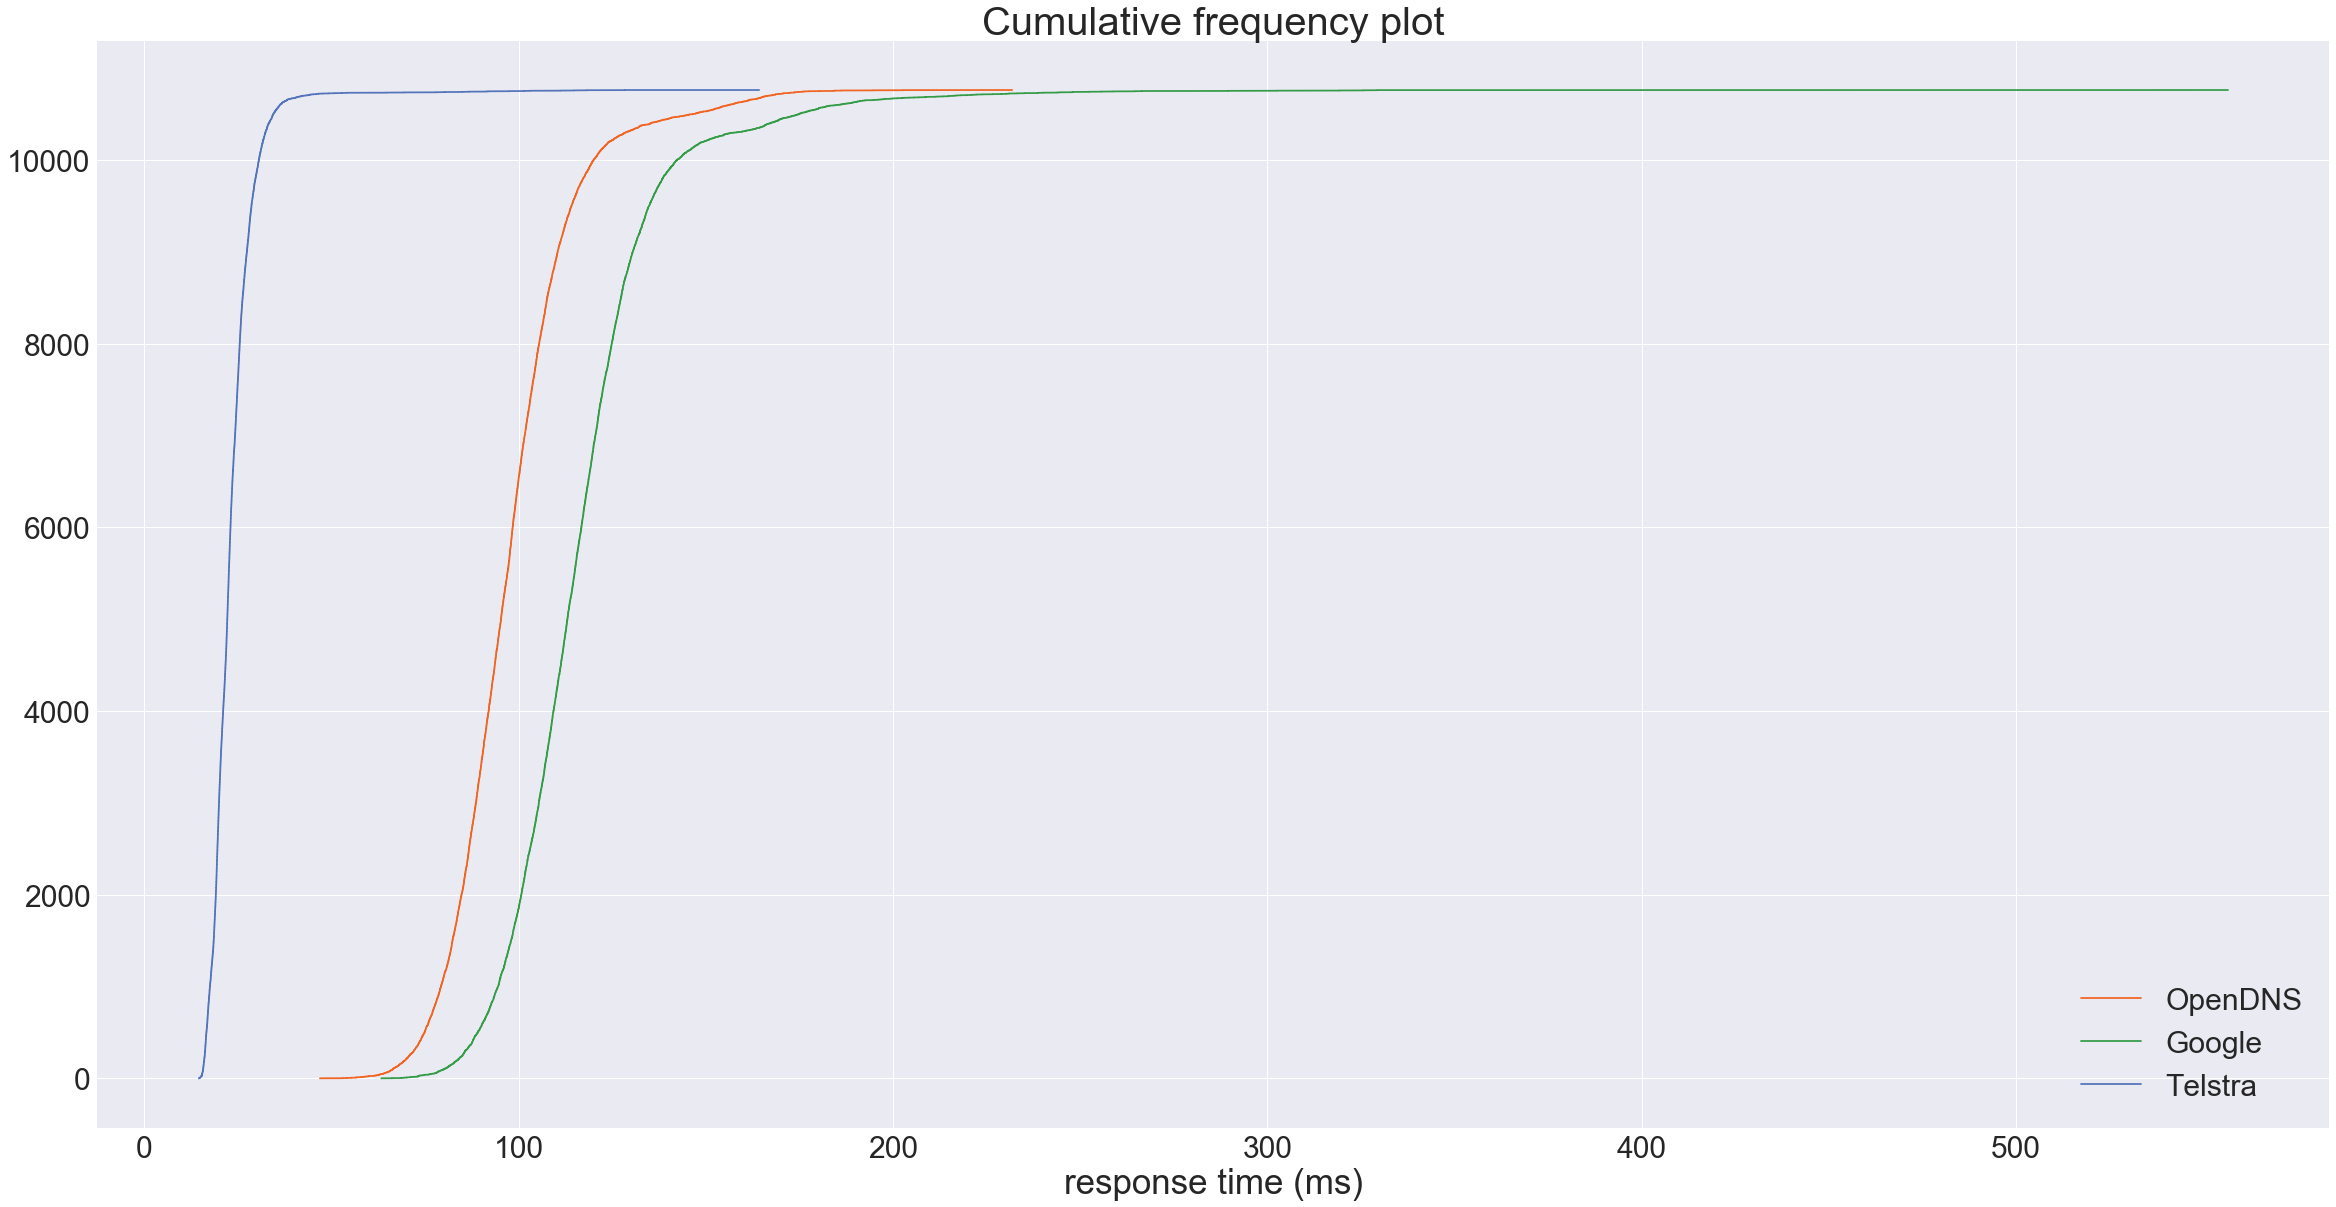

In [13]:
import numpy as np
import matplotlib.pyplot as plt

for dns in dns_providers:
    plt.step(np.sort(list(data[dns])), np.arange(len(data)), label=dns, color=colors[dns])
plt.tick_params(axis='both', which='major', labelsize=30)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.xlabel('response time (ms)', fontsize=35)
plt.title('Cumulative frequency plot', size=40)
plt.legend(prop={'size': 30})
plt.show()

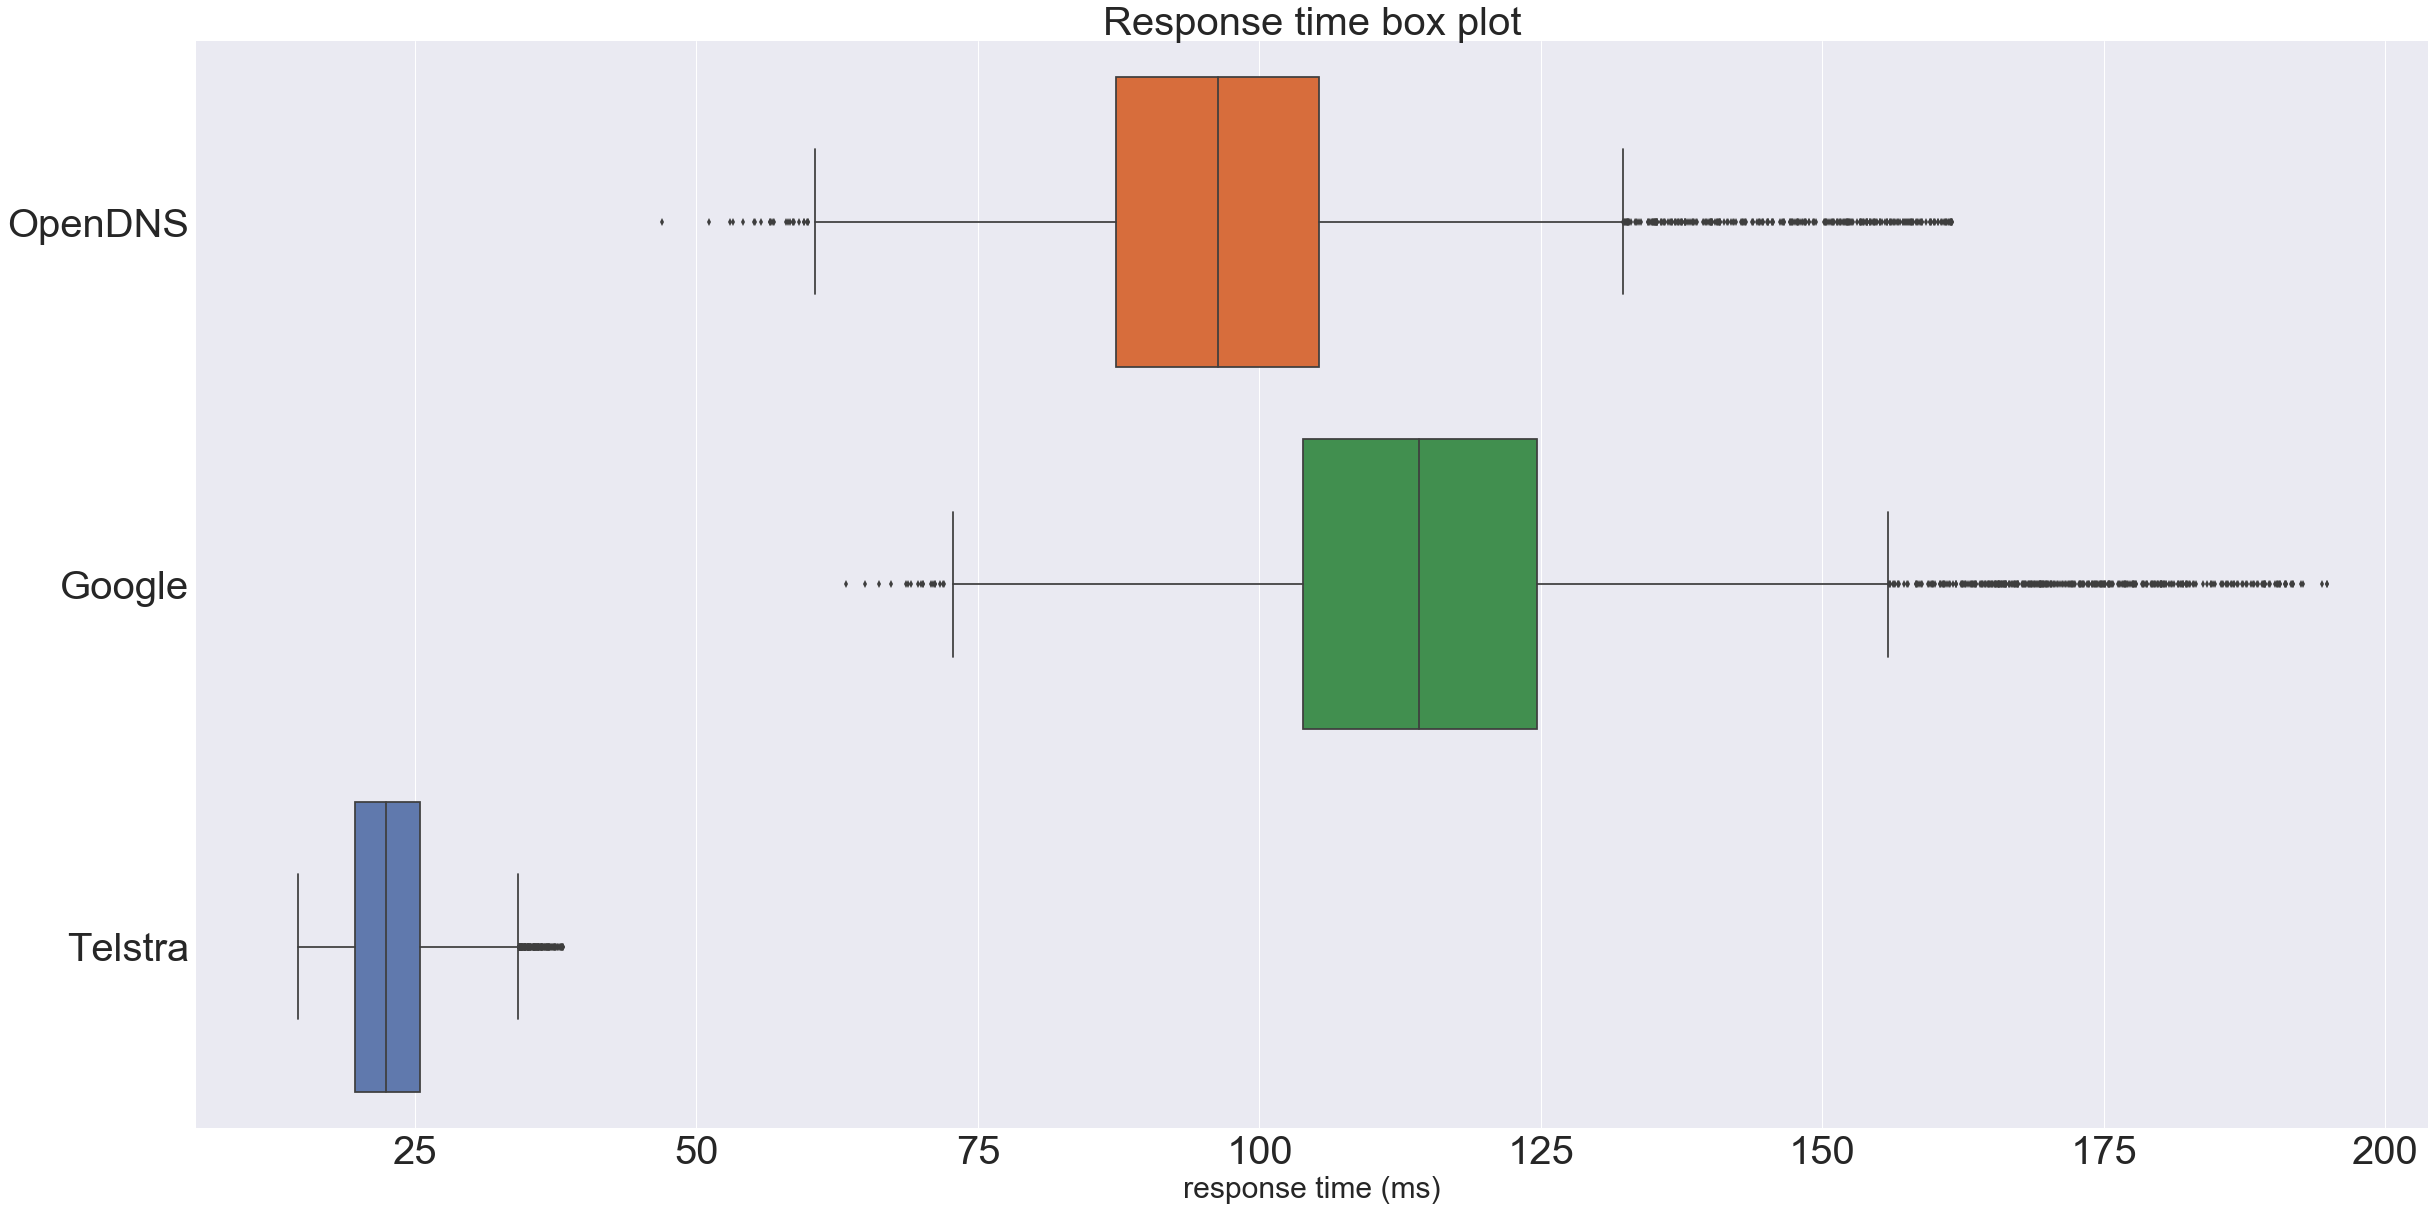

In [14]:
rcParams['figure.figsize'] = 40, 20
dns1_wo_outliers = data[dns_providers[0]] <= data[dns_providers[0]].quantile(0.99) 
dns2_wo_outliers = data[dns_providers[1]] <= data[dns_providers[1]].quantile(0.99) 
dns3_wo_outliers = data[dns_providers[2]] <= data[dns_providers[2]].quantile(0.99)
ax = sns.boxplot(data=data[dns1_wo_outliers & dns2_wo_outliers & dns3_wo_outliers], orient='h', palette=['#f16422','#349c47','#5374ba'])
plt.tick_params(axis='both', which='major', labelsize=40)
plt.tick_params(axis='both', which='minor', labelsize=15)
plt.xlabel('response time (ms)', fontsize=30)
plt.title('Response time box plot', size=40)
plt.show()

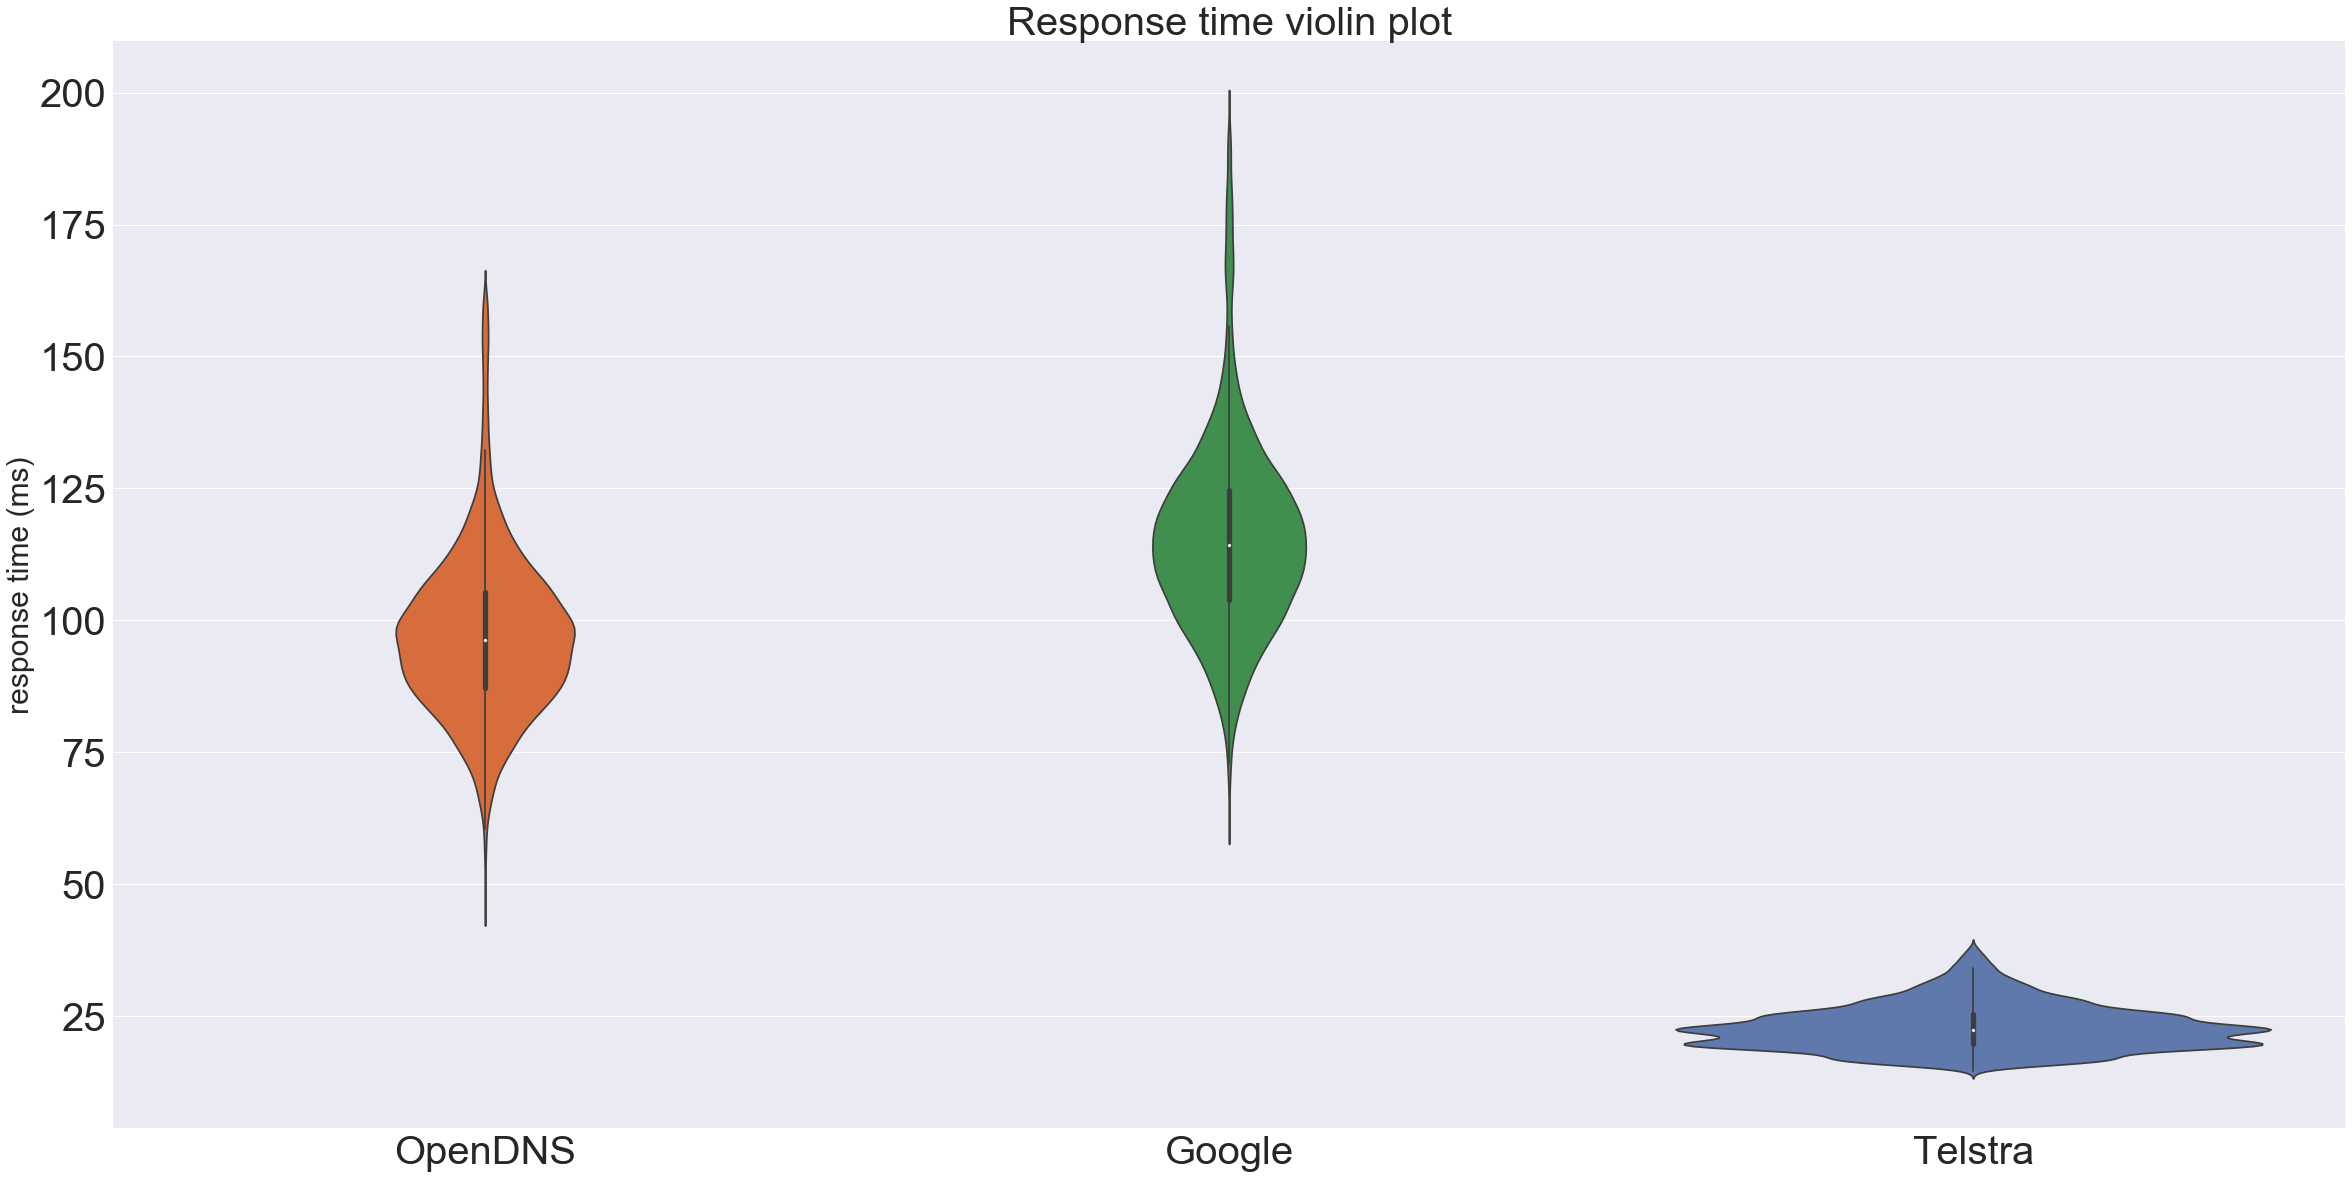

In [15]:
rcParams['figure.figsize'] = 40, 20
dns1_wo_outliers = data[dns_providers[0]] <= data[dns_providers[0]].quantile(0.99) 
dns2_wo_outliers = data[dns_providers[1]] <= data[dns_providers[1]].quantile(0.99) 
dns3_wo_outliers = data[dns_providers[2]] <= data[dns_providers[2]].quantile(0.99)
ax = sns.violinplot(data=data[dns1_wo_outliers & dns2_wo_outliers & dns3_wo_outliers], palette=['#f16422','#349c47','#5374ba'])
plt.tick_params(axis='both', which='major', labelsize=40)
plt.tick_params(axis='both', which='minor', labelsize=15)
plt.ylabel('response time (ms)', fontsize=30)
plt.title('Response time violin plot', size=40)
plt.show()

In [16]:
fig = ff.create_distplot([data[dns] for dns in dns_providers], dns_providers, bin_size=0.05, colors=[colors[dns] for dns in dns_providers], show_rug=True)
#fig['layout']['yaxis'].update(tickformat=".0%")
fig['layout'].update(height=600)
py.iplot(fig)